<a href="https://colab.research.google.com/github/daisuke-8080/kaggle_jpx/blob/main/%E5%90%89%E7%94%B0%E5%8D%9A%E9%A2%A8%E3%81%AE%E5%86%99%E7%9C%9F%E3%81%AB%E5%A4%89%E6%8F%9B%E3%81%99%E3%82%8BCycleGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 画像は常にテンソルとして保持する。確認のために画像の表示を行なう関数や、ストレージへの保存をする関数の入力もテンソルとする（つまりPIL.Imageクラスで入力しないようにする）
よってそのような関数の中ではテンソルの次元を(C, H, W)から(H, W, C)にpermuteする

In [ ]:
import numpy as np
import torch
import torchvision
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
!pip install icrawler

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from icrawler.builtin import GoogleImageCrawler

#GoogleDriveの保存先のフォルダ名
folder_name = "吉田博3/画像フォルダ"
#GoogleDriveの保存先のフォルダまでの絶対Pass
my_dir_name = '/content/drive/MyDrive/CycleGAN/' + folder_name
search_keyword = '吉田博　作品'

#Crawler インスタンスの取得
google_crawler = GoogleImageCrawler(
    feeder_threads = 1,
    parser_threads = 1,
    downloader_threads = 4,
    storage = {'root_dir' : my_dir_name})
#フィルターの設定

filters = dict(
    size = 'large',
)

#Crawler稼働
google_crawler.crawl(keyword=search_keyword, filters=filters, offset=0, max_num=1000, min_size=(200,200), max_size=None)

ERROR:downloader:Response status code 403, file http://img05.img.mei-shu.net/Uploads/sjmh/hiroshi-yoshida/fplh1tacvrz.jpg
ERROR:downloader:Response status code 403, file http://img05.img.mei-shu.net/Uploads/sjmh/hiroshi-yoshida/g1qmj14hlfi.jpg
ERROR:downloader:Response status code 403, file http://img05.img.mei-shu.net/Uploads/sjmh/hiroshi-yoshida/4idzczxswxs.jpg


In [ ]:
#Googleドライブからデータセットのoriginalを作成

from torchvision import transforms
transforms_dict = {
    'train' : transforms.Compose([
        transforms.RandomResizedCrop(size=256, scale=(1, 1)),
        transforms.RandomRotation(degrees=[-10, 10], expand=False),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),

    'test' : transforms.Compose([
        transforms.RandomResizedCrop(size=256, scale=(1, 1)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])        
    ])
}

art_dataset_org = torchvision.datasets.ImageFolder(root='/content/drive/MyDrive/CycleGAN/吉田博', transform=transforms_dict['train'])
photo_dataset_org = torchvision.datasets.ImageFolder(root='/content/drive/MyDrive/CycleGAN/世界絶景写真', transform=transforms_dict['train'])

In [ ]:
len(photo_dataset_org)

253

In [ ]:
photo_dataset_org[61][0]

tensor([[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         ...,
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],

        [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         ...,
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],

        [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
         [-1.8044, -1.8044, -1.8044,  ..., -1

In [ ]:
def SolePictToTensor(filepass):
  #PILとして読み込み
  image = Image.open(filepass)
  image = image.convert('RGB')
  #Torch.Tensorへ変換
  image_tensor = transforms_dict['test'](image)
  return image_tensor

In [ ]:
#テンソル化された画像を入力して画像表示する
def show_image(image):
    img = image.permute(1,2,0) 
    plt.imshow(img)
    plt.show()

In [ ]:
#テンソル化された画像とpassを入力して画像を入力されたpassへ保存する
def save_image(image, filepass):
  TensorToPIL = transforms.ToPILImage(mode="RGB")
  image = TensorToPIL(image)
  image.save(filepass)
  return

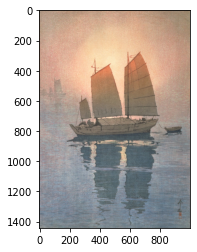

In [ ]:
#フォルダから単品で画像を取ってきて表示するだけ
image_sole = Image.open('/content/drive/MyDrive/CycleGAN/吉田博/画像フォルダ/000022 (1).jpg')
image_sole = image_sole.convert('RGB')
plt.imshow(image_sole)
plt.show()

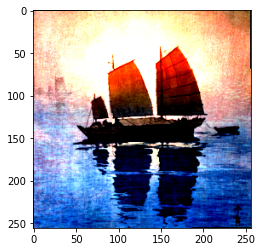

In [ ]:
#上の処理でとってきた単品の画像を正規化してtrainのtransformを通して表示
image_sole = transforms_dict['train'](image_sole)
show_image(image_sole)

In [ ]:
def reverse_image(image):
  #標準化されている画像を元に戻す
  image = image.mul(torch.FloatTensor([0.229, 0.224, 0.225]).view(3,1,1))
  image = image.add(torch.FloatTensor([0.485, 0.456, 0.406]).view(3,1,1)).detach()
  #サイズを1000*1000にResizeする
  Reverse_resize_transform = transforms.Resize(1000)
  image = Reverse_resize_transform(image)
  return image

In [ ]:
#image_soleの標準化を戻して保存してみる
image_sole = reverse_image(image_sole)
save_image(image_sole, '/content/drive/MyDrive/CycleGAN/動作確認.jpg')

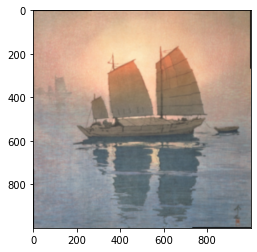

In [ ]:
show_image(image_sole)

In [ ]:
from  torch.utils.data import Dataset

#CycleGAN の学習に使用する二つの種類の画像をペアとして提供するデータセット
class CycleGANDataset(Dataset):
  def __init__(self, art_dataset_org, photo_dataset_org):
    #データ数多い方が少ない方に合わせるスライシングをするために、少ない方のデータ数を取得
    self.clip_index = min(len(art_dataset_org), len(photo_dataset_org))

    #元データセットのインデックス配列取得  
    art_dataset_org_indices = np.arange(len(art_dataset_org))
    photo_dataset_org_indices = np.arange(len(photo_dataset_org))

    self.art_dataset = torch.utils.data.Subset(art_dataset_org, art_dataset_org_indices[:self.clip_index])
    self.photo_dataset = torch.utils.data.Subset(photo_dataset_org, photo_dataset_org_indices[:self.clip_index])

  def __getitem__(self, index):
    art_image = self.art_dataset[index][0]
    photo_image= self.photo_dataset[index][0]

    return art_image, photo_image

  def __len__(self):
    return self.clip_index


In [ ]:
#実際の学習に使用するデータセットのインスタンス
PairedDataset = CycleGANDataset(art_dataset_org, photo_dataset_org)

In [ ]:
#実際の学習に使用するデータローダー
Paired_dataLoader = torch.utils.data.DataLoader(PairedDataset, batch_size=1, shuffle=True)

In [ ]:
art_image_ex, photo_image_ex = PairedDataset[98]
len(PairedDataset)

206

In [ ]:
dataset_ex = next(iter(Paired_dataLoader))
art_image_ex, photo_image_ex = dataset_ex

In [ ]:
dataset_ex[0]

tensor([[[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          ...,
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],

         [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          ...,
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],

         [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
          [-1.8044, -1.8044, -

In [ ]:
art_image_ex.size()

torch.Size([1, 3, 256, 256])

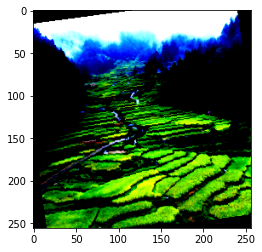

In [ ]:
show_image(photo_image_ex.squeeze(0))

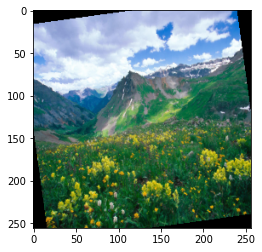

In [ ]:
show_image(reverse_image(photo_image_ex))

In [ ]:
len(Paired_dataLoader)

206

In [ ]:
#ResidualBlockの定義
class ResidualBlock(nn.Module):
  def __init__(self, input_features):
    super().__init__()

    self.conv_block = nn.Sequential(
        nn.ReflectionPad2d(1),
        nn.Conv2d(input_features, input_features, 3),
        nn.InstanceNorm2d(input_features),
        nn.ReLU(inplace=True),
        nn.ReflectionPad2d(1),
        nn.Conv2d(input_features, input_features, 3),
        nn.InstanceNorm2d(input_features)
    )

  def forward(self, x):
    return x + self.conv_block(x)

In [ ]:
#生成器の定義
class Generator(nn.Module):
  def __init__(self, input_channel_num, output_channel_num):
    super().__init__()

    self.model = nn.Sequential(
        nn.ReflectionPad2d(3),
        nn.Conv2d(input_channel_num, 64, 7),
        nn.InstanceNorm2d(64),
        nn.ReLU(inplace=True),

        nn.Conv2d(64, 128, 3, stride=2, padding=1),
        nn.InstanceNorm2d(128),
        nn.ReLU(inplace=True),

        nn.Conv2d(128, 256, 3, stride=2, padding=1),
        nn.InstanceNorm2d(256),
        nn.ReLU(inplace=True),

        ResidualBlock(256),
        ResidualBlock(256),
        ResidualBlock(256),
        ResidualBlock(256),
        ResidualBlock(256),
        ResidualBlock(256),
        ResidualBlock(256),
        ResidualBlock(256),
        ResidualBlock(256),

        nn.ConvTranspose2d(256, 128, 3, stride=2, padding=1, output_padding=1),
        nn.InstanceNorm2d(128),
        nn.ReLU(inplace=True),        

        nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),
        nn.InstanceNorm2d(64),
        nn.ReLU(inplace=True),

        nn.ReflectionPad2d(3),
        nn.Conv2d(64, 3, 7),
        nn.Tanh()
    )

  def forward(self,  x):
    return self.model(x)

In [ ]:
#識別器の定義
class Discriminator(nn.Module):
  def __init__(self, input_channel_num):
    super().__init__()

    self.model = nn.Sequential(
        nn.Conv2d(input_channel_num, 64,  4, stride=2, padding=1),
        nn.LeakyReLU(0.2, inplace=True),

        nn.Conv2d(64, 128,  4, stride=2, padding=1),
        nn.InstanceNorm2d(128),
        nn.LeakyReLU(0.2, inplace=True),

        nn.Conv2d(128, 256,  4, stride=2, padding=1),
        nn.InstanceNorm2d(256),
        nn.LeakyReLU(0.2, inplace=True),        

        nn.Conv2d(256, 512, 4, padding=1),
        nn.InstanceNorm2d(512),
        nn.LeakyReLU(0.2, inplace=True),   

        nn.Conv2d(512, 1, 4, padding=1)
    )

  def forward(self, x):
    x = self.model(x)
    return F.avg_pool2d(x, x.size()[2:]).view(x.size()[0], -1)

In [ ]:
#過去に生成した画像を50iter分バッファとして保持する
class ReplayBuffer():
  def __init__(self, max_iter_size=50):
    self.max_iter_size = max_iter_size
    self.data = []

  def push_and_pop(self, data):
    #取り出す画像を入れておくリスト
    to_return = []
    for element in data.data:
          #取り出す画像を入れておくリスト
        element = torch.unsqueeze(element, 0)
        #まだ保存容量に達していないときは保存してから新しい入力をそのまま出力
        if len(self.data) < self.max_iter_size:
          self.data.append(element)
          to_return.append(element)
        else:
          #五割の確率で保存された画像の中から取り出して出力し、その後はあたらしい入力と差し替える
          if np.random.uniform(0,1) > 0.5:
            i = np.random.randint(0, self.max_iter_size -1)
            to_return.append(self.data[i].clone())
            self.data[i] = element
          #保存せずに新しい入力をそのまま出力
          else:
            to_return.append(element)
      
    return torch.cat(to_return)

In [ ]:
#学習率の調整を行うクラス
class LambdaLR():
  def __init__(self, n_epochs, offset, decay_start_epoch):
    self.n_epochs = n_epochs
    self.offset = offset
    self.decay_start_epoch = decay_start_epoch

  def step(self, epoch):
    return 1.0 - max(0, epoch + self.offset - self.decay_start_epoch) / (self.n_epochs - self.decay_start_epoch)

In [ ]:
#重みパラメーターの初期化
def weights_init_normal(m):
  classname = m.__class__.__name__
  if classname.find('Conv') != -1:
      torch.nn.init.normal(m.weight.data, 0.0, 0.02)
  elif classname.find('BatchNorm2d') != -1:
      torch.nn.init.normal(m.weight.data, 1.0, 0.02)
      torch.nn.init.constant(m.bias.data, 0.0)

In [ ]:
#ハイパーパラメータ等の設定を一手に担うクラス
class Opts():
  def __init__(self):
    self.start_epoch = 0
    self.n_epochs = 250
    self.lr = 0.0002
    self.decay_epoch = 200
    self.image_size = 256
    self.input_channel_num = 3
    self.output_channel_num = 3
    self.cpu = False
    self.n_cpu = 8
    self.device = device = "cuda" if torch.cuda.is_available() else "cpu"
    self.load_weitht = False

In [ ]:
#ハイパーパラメータ等の定義
opt = Opts()

#生成器の定義
netG_A2B = Generator(opt.input_channel_num, opt.output_channel_num)
netG_B2A = Generator(opt.input_channel_num, opt.output_channel_num)

#識別器の定義
netD_A = Discriminator(opt.input_channel_num)
netD_B = Discriminator(opt.input_channel_num)

if torch.cuda.is_available():
  netG_A2B.to(opt.device)
  netG_B2A.to(opt.device)
  netD_A.to(opt.device)
  netD_B.to(opt.device)

#損失関数
criterion_GAN = torch.nn.MSELoss()
criterion_cycle = torch.nn.L1Loss()
criterion_identity = torch.nn.L1Loss()

#Optimizers LRschedulers

#生成器の損失はドメインAの画像の損失とドメインBの画像の損失をまとめて計算するため、
#itertool.chainで二つの生成器のパラメータ(のiterator)を連結してから取り出して最適化する
import itertools
optimizer_G = torch.optim.Adam(itertools.chain(netG_A2B.parameters(), netG_B2A.parameters()), lr=opt.lr, betas=(0.5, 0.999))

optimizer_D_A = torch.optim.Adam(netD_A.parameters(), lr=opt.lr, betas=(0.5, 0.999))
optimizer_D_B = torch.optim.Adam(netD_B.parameters(), lr=opt.lr, betas=(0.5, 0.999))

lr_scheduler_G = torch.optim.lr_scheduler.LambdaLR(optimizer_G, lr_lambda=LambdaLR(opt.n_epochs, opt.start_epoch, opt.decay_epoch).step)
lr_scheduler_D_A = torch.optim.lr_scheduler.LambdaLR(optimizer_D_A , lr_lambda=LambdaLR(opt.n_epochs, opt.start_epoch, opt.decay_epoch).step)
lr_scheduler_D_B = torch.optim.lr_scheduler.LambdaLR(optimizer_D_B , lr_lambda=LambdaLR(opt.n_epochs, opt.start_epoch, opt.decay_epoch).step)


#損失関数に渡すターゲットラベル
target_real = torch.tensor([[1.0]], device=opt.device, requires_grad=False).float()
target_fake =  torch.tensor([[0.0]], device=opt.device, requires_grad=False).float()

#過去に生成した画像のバッファ
fake_A_buffer = ReplayBuffer(50)
fake_B_buffer = ReplayBuffer(50)

In [ ]:
target_real = torch.tensor([[1.0]], device=opt.device, requires_grad=False).float()
target_real.dtype

torch.float32

In [ ]:
photo_image_ex.to('cpu')

In [ ]:
y = netD_B(photo_image_ex) 
y.size()

torch.Size([1, 1])

In [ ]:
y.dtype

torch.float32

In [ ]:
target_real.size()

torch.Size([1, 1])

In [ ]:
criterion_GAN(y,target_real)

tensor(1.0743, dtype=torch.float64, grad_fn=<MseLossBackward0>)

In [ ]:
target_real

tensor([[1.]], dtype=torch.float64)

In [ ]:
from tqdm import tqdm
#学習の開始
epoch_counter = 0
for epoch in tqdm(range(opt.start_epoch, opt.n_epochs)):
  epoch_counter += 1
  for image_pair in Paired_dataLoader:
    real_A =  image_pair[0].to(opt.device)
    real_B =  image_pair[1].to(opt.device)

    #_____________生成器の学習______________

    optimizer_G.zero_grad()

    #同一性損失の計算(L1損失　identity_loss )
    #AからBを作る生成期にBと同じような特徴の入力が来たときになるべく変化させないで出力させるようにする処理
    same_B = netG_A2B(real_B)
    loss_identity_A = criterion_identity(same_B, real_B)*5.0

    #上と逆　BからAを作る生成期にAと同じような特徴の入力が来たときになるべく変化させないで出力させるようにする処理
    same_A = netG_B2A(real_A)
    loss_identity_B = criterion_identity(same_A, real_A)*5.0

    #敵対性損失 (GAN loss)
    fake_B = netG_A2B(real_A)
    pred_fake = netD_B(fake_B)
    loss_GAN_A2B = criterion_GAN(pred_fake, target_real)

    fake_A = netG_B2A(real_B)
    pred_fake = netD_A(fake_A)
    loss_GAN_B2A = criterion_GAN(pred_fake, target_real)

    #サイクル一貫性損失 (cycle loss)
    recovered_A = netG_B2A(fake_B)
    loss_cycle_ABA = criterion_cycle(recovered_A, real_A)*10.0

    recovered_B = netG_A2B(fake_A)
    loss_cycle_BAB = criterion_cycle(recovered_B, real_B)*10.0

    #生成器の総合損失
    loss_G =  loss_identity_A + loss_identity_B + loss_GAN_A2B + loss_GAN_B2A + loss_cycle_ABA + loss_cycle_BAB
    loss_G.backward()

    optimizer_G.step()

    #_____________Aの識別器位の学習______________
    optimizer_D_A.zero_grad()

    #本物Aの識別と損失
    pred_real = netD_A(real_A)
    loss_D_real = criterion_GAN(pred_real, target_real)
  
    #生成Aの識別と損失
    fake_A = fake_A_buffer.push_and_pop(fake_A)
    pred_fake = netD_A(fake_A.detach())
    loss_D_fake = criterion_GAN(pred_fake, target_fake)

    #Aの識別器の総合損失
    loss_D_A = (loss_D_real + loss_D_fake)*0.5
    loss_D_A.backward()

    optimizer_D_A.step()

    #_____________Bの識別器位の学習______________
    optimizer_D_B.zero_grad()

    #本物Bの識別と損失
    pred_real = netD_B(real_B)
    loss_D_real = criterion_GAN(pred_real, target_real)

    #偽物Bの識別と損失
    fake_B = fake_B_buffer.push_and_pop(fake_B)
    pred_fake = netD_B(fake_B.detach())
    loss_D_fake = criterion_GAN(pred_fake, target_fake)

    #Bの識別器の総合損失
    loss_D_B = (loss_D_real + loss_D_fake)*0.5
    loss_D_B.backward()

    optimizer_D_B.step()

  #50epochごとに損失確認
  if epoch_counter % 10 == 0:
      print('Epoch[{}]({}/{}) loss_G: {:.4f} loss_G_identity: {:.4f} loss_G_GAN: {:.4f} loss_G_cycle: {:.4f} loss_D: {:.4f}'.format(
                epoch_counter, epoch_counter, opt.n_epochs, loss_G, (loss_identity_A + loss_identity_B),
                (loss_GAN_A2B + loss_GAN_B2A), (loss_cycle_ABA + loss_cycle_BAB), (loss_D_A + loss_D_B)
                ))


  lr_scheduler_G.step()
  lr_scheduler_D_A.step()
  lr_scheduler_D_B.step()


    

  0%|          | 0/250 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
  4%|▍         | 10/250 [23:15<9:00:20, 135.08s/it]

Epoch[10](10/250) loss_G: 23.0196 loss_G_identity: 6.9485 loss_G_GAN: 1.9332 loss_G_cycle: 14.1380 loss_D: 0.0070


  8%|▊         | 20/250 [45:37<8:34:49, 134.30s/it]

Epoch[20](20/250) loss_G: 14.5403 loss_G_identity: 4.1244 loss_G_GAN: 1.7807 loss_G_cycle: 8.6352 loss_D: 0.0183


 12%|█▏        | 30/250 [1:08:00<8:12:37, 134.35s/it]

Epoch[30](30/250) loss_G: 14.1466 loss_G_identity: 3.3779 loss_G_GAN: 1.9634 loss_G_cycle: 8.8053 loss_D: 0.0028


 16%|█▌        | 40/250 [1:30:24<7:50:25, 134.41s/it]

Epoch[40](40/250) loss_G: 13.3338 loss_G_identity: 3.8648 loss_G_GAN: 1.8260 loss_G_cycle: 7.6430 loss_D: 0.0023


 20%|██        | 50/250 [1:52:49<7:28:22, 134.51s/it]

Epoch[50](50/250) loss_G: 16.3421 loss_G_identity: 4.6326 loss_G_GAN: 2.1259 loss_G_cycle: 9.5836 loss_D: 0.0035


 24%|██▍       | 60/250 [2:15:12<7:05:21, 134.32s/it]

Epoch[60](60/250) loss_G: 26.8242 loss_G_identity: 8.2283 loss_G_GAN: 1.9820 loss_G_cycle: 16.6139 loss_D: 0.0013


 28%|██▊       | 70/250 [2:37:34<6:42:37, 134.21s/it]

Epoch[70](70/250) loss_G: 14.2528 loss_G_identity: 3.9960 loss_G_GAN: 1.8667 loss_G_cycle: 8.3901 loss_D: 0.0024


 32%|███▏      | 80/250 [2:59:55<6:19:49, 134.05s/it]

Epoch[80](80/250) loss_G: 12.7452 loss_G_identity: 3.5526 loss_G_GAN: 2.0069 loss_G_cycle: 7.1857 loss_D: 0.0005


 36%|███▌      | 90/250 [3:22:16<5:57:47, 134.17s/it]

Epoch[90](90/250) loss_G: 12.6562 loss_G_identity: 3.4387 loss_G_GAN: 1.9373 loss_G_cycle: 7.2802 loss_D: 0.0033


 39%|███▉      | 97/250 [3:37:54<5:41:43, 134.01s/it]

In [ ]:
#重みパラメータの保存
learned_parameters_pass_A2B = '/content/drive/MyDrive/CycleGAN/netG_art2photo.pth'
learned_parameters_pass_B2A = '/content/drive/MyDrive/CycleGAN/netG_photo2art.pth'

torch.save(netG_A2B.state_dict(), learned_parameters_pass_A2B)
torch.save(netG_B2A.state_dict(), learned_parameters_pass_B2A)

In [ ]:
#テストの設定

#生成器の用意
netG_A2B = Generator(opt.input_channel_num, opt.output_channel_num).to(opt.device)
netG_B2A = Generator(opt.input_channel_num, opt.output_channel_num).to(opt.device)

#重みパラメーターの読み込み
netG_A2B.load_state_dict(torch.load(learned_parameters_pass_A2B))
netG_B2A.load_state_dict(torch.load(learned_parameters_pass_B2A))

netG_A2B.eval()
netG_B2A.eval()

# 生成画像の保存ディレクトリpass
generated_A_pass = '/content/drive/MyDrive/CycleGAN/吉田博_Generated/'
generated_B_pass = '/content/drive/MyDrive/CycleGAN/世界絶景写真_Generated/'


#テスト用のdatasetのoriginal
art_dataset_org = torchvision.datasets.ImageFolder(root='/content/drive/MyDrive/CycleGAN/吉田博3', transform=transforms_dict['test'])
photo_dataset_org = torchvision.datasets.ImageFolder(root='/content/drive/MyDrive/CycleGAN/世界絶景写真3', transform=transforms_dict['test'])

#テストに使用するデータセットのインスタンス
PairedDataset_for_test = CycleGANDataset(art_dataset_org, photo_dataset_org)
#テストに使用するデータローダー
Paired_dataLoader_for_test = torch.utils.data.DataLoader(PairedDataset, batch_size=1, shuffle=True)


In [ ]:
dataset = next(iter(Paired_dataLoader_for_test))
art = dataset[0].to(opt.device)
photo = dataset[1].to(opt.device)

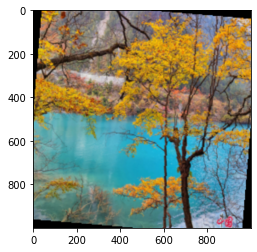

In [ ]:
photo = photo.to('cpu').squeeze(0)
photo = reverse_image(photo)
show_image(photo)

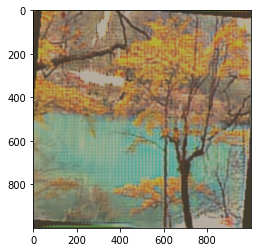

In [ ]:
art_ = netG_B2A(photo)
art_ = art_.to('cpu').squeeze(0)
art_ = reverse_image(art_)
show_image(art_)

In [ ]:
from tqdm import tqdm
#テストの実行と生成画像の保存
generated_image_counter = 0
num_generate = 50
for image_pair in Paired_dataLoader_for_test:
  generated_image_counter += 1

  real_A = image_pair[0].to(opt.device)
  real_B = image_pair[1].to(opt.device)


  generated_A = netG_B2A(real_B)
  generated_B = netG_A2B(real_A)

  generated_A = generated_A.squeeze(0).to('cpu')
  generated_B = generated_B.squeeze(0).to('cpu')

  #正規化が施されているため元に戻す
  generated_A = reverse_image(generated_A)
  generated_B = reverse_image(generated_B)

  #生成されたAの保存
  file_name_A = generated_A_pass + f'{generated_image_counter}' + '.jpg'
  save_image(generated_A, file_name_A)
  #生成されたBの保存
  file_name_B = generated_B_pass + f'{generated_image_counter}' + '.jpg'
  save_image(generated_B, file_name_B)

  #指定の枚数を生成し終えたらループを抜ける
  if generated_image_counter > num_generate:
    break
